#### Random Forest -classification, example 1 - Social Network Ads, data (compare to SVC -code previously!) + optimization with RandomizedSearch

**Notice here how all the randomness has been locked down for reproducibility!**

In [20]:
# random seed locking code original from ChatGPT => has been tested that it works
import random
import os

# Set a fixed seed value
SEED = 7601278

# 1. Set Python's built-in random module seed
random.seed(SEED)
import numpy as np

# 2. Set NumPy random seed
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# 4. Set environment variables (affects some backend randomness)
os.environ['PYTHONHASHSEED'] = str(SEED)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [21]:
# load data 
df = pd.read_csv("Social_Network_Ads.csv")

In [22]:
df.sample(5)

,User ID,Gender,Age,EstimatedSalary,Purchased
379,15749381,Female,58,23000,1
168,15789815,Male,29,148000,1
2,15668575,Female,26,43000,0
42,15772798,Male,35,108000,0
170,15587013,Male,21,88000,0


In [23]:
# drop the User ID since it's more like a background variable
# from some kind of data system etc. no statistical meaning
df = df.drop("User ID", axis=1)

In [24]:
# WITH BOOLEAN TEXT VALUES => LabelEncoder is the best option
# since we can convert all of the boolean variables all at once
# any text column with exactly two options is considered a boolean

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder

# list of all boolean variables we want to convert
variables = ['Gender']

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [25]:
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


#### X/y and train/test split

In [26]:
# a small trick => use everything else except, the target
X = df.drop("Purchased", axis=1)

# our target variable is y
y = df['Purchased']

In [27]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

## Attempt finding optimal parameters for Random Forest

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# initialize testable parameters
# Since we have to wrap LinearSVC into CalibratedClassifierCV
# we have to use this estimator__ prefix in the parameters
param_dist = {
    'n_estimators': [25, 30, 35, 40, 45, 50, 55, 60, 70, 75, 85, 100, 125],
    'max_depth': [3,4,5,6,7,8,9,10,11,12],
}

# start finding the optimal parameters with RandomizedSearchCV!
# RandomizedSearchCV is usually way faster than GridSearchCV
# .... but it's also mostly random
test_model = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), param_dist, n_iter=2000, verbose=3, n_jobs=-1, cv=5, random_state=SEED)
test_model.fit(X_train, y_train)

c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 130 is smaller than n_iter=2000. Running 130 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 130 candidates, totalling 650 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...state=7601278)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [3, 4, ...], 'n_estimators': [25, 30, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",2000
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 

In [29]:
test_model.best_params_

{'n_estimators': 25, 'max_depth': 3}

#### Create classifier and train the model

In [30]:
# code as usual
# model = LogisticRegression()

# you have to wrap the linear SVC into CalibratedClassifierCV
# for probabilities to work correctly in error metrics
# in other words, because LinearSVC() doesn't support probability=True
# we have to wrap it around CalibratedClassifierCV()

# model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=8, random_state=SEED, n_jobs=1))
model = make_pipeline(RandomForestClassifier(n_estimators=25, max_depth=3, random_state=SEED, n_jobs=1))
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('randomforestclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",25
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",3
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at eac

#### Classification error metrics

In [31]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [32]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.92      0.97      0.95        37

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


Model overall accuracy: 96.00%


### Error metrics

[[60  3]
 [ 1 36]]


<Axes: >

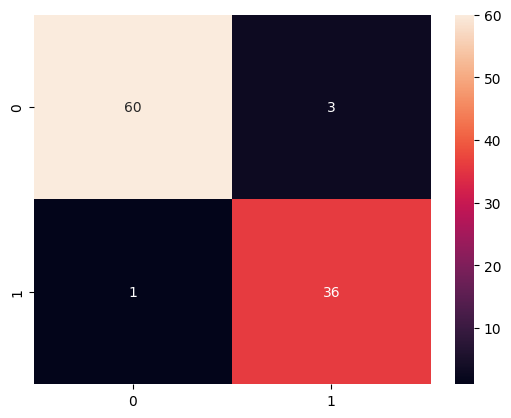

In [33]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

In [34]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model
# roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1])
roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1])

0.9897039897039897

#### Using the model in practice

In [35]:
tester_row = {
    'Gender': 0, 
    'Age': 52, 
    'EstimatedSalary': 75000 
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])
# tester_row = sc.transform(tester_row)

print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Did this customer buy the service (Yes/No):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.394522 0.605478]]

Did this customer buy the service (Yes/No):
Yes
-------------------
